In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import ecdf
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

pd.options.mode.chained_assignment = None

SEED = 69

# Sessa Empirical Estimator (SEE)

Sessa Empirical Estimator (SEE) – An Implementation in Python.

## Objectives

1. Compute the temporal intervals (gaps) between consecutive fills.
2. Filter out extremely long gaps by retaining only the lower 80% of the empirical cumulative distribution.
3. Standardize these intervals.
4. Cluster the standardized intervals using:
   - **K-Means**: As in the original SEE
   - **Density-Based Spatial Clustering of Applications with Noise (DBSCAN)**: As an alternative clustering method
5. Use the median of each cluster’s intervals as the estimated duration.
6. Compare the results between the two clustering approaches.

## Dataset

We will be using an artificial data set [`med_events.csv`](med_events.csv). The file is generated from `med.events` from [AdhereR](https://rdrr.io/cran/AdhereR/man/med.events.html).

In [2]:
med_events = pd.read_csv("med_events.csv")

med_events["DATE"] = pd.to_datetime(med_events["DATE"])

med_events.groupby("PATIENT_ID").first().head(10)

,DATE,PERDAY,CATEGORY,DURATION
PATIENT_ID,,,,
1,2033-04-26,4,medA,50
2,2036-01-20,4,medA,50
3,2042-04-13,4,medA,50
4,2032-05-01,4,medA,50
5,2031-10-26,8,medA,30
6,2037-01-07,4,medA,50
7,2042-04-05,2,medA,100
8,2034-04-08,6,medA,50
9,2032-03-01,2,medA,50


We will be making a copy of `med_events` with different column names:

- `pnr`: Patient ID
- `eksd`: Dispensing date in `MM/DD/YYYY` format
- `perday`: The daily dosage interval
- `ATC`: Anatomical Therapeutic Chemical
- `dur_original`: Original duration of the medication

In [3]:
tidy = med_events.copy()

tidy.columns = ["pnr", "eksd", "perday", "ATC", "dur_original"]

tidy.groupby("pnr").first().head(10)

,eksd,perday,ATC,dur_original
pnr,,,,
1,2033-04-26,4,medA,50
2,2036-01-20,4,medA,50
3,2042-04-13,4,medA,50
4,2032-05-01,4,medA,50
5,2031-10-26,8,medA,30
6,2037-01-07,4,medA,50
7,2042-04-05,2,medA,100
8,2034-04-08,6,medA,50
9,2032-03-01,2,medA,50


## SEE Using K-Means Clustering

In [ ]:
def SEE_KMeans(atc: str, data=tidy) -> pd.DataFrame:
    df = data[data["ATC"] == atc].copy()

    drug_see_p0 = df.copy()
    drug_see_p1 = df.copy()

    drug_see_p1 = drug_see_p1.sort_values(by=["pnr", "eksd"])
    drug_see_p1["prev_eksd"] = drug_see_p1.groupby("pnr")["eksd"].shift(1)
    drug_see_p1 = drug_see_p1.dropna(subset=["prev_eksd"])

    drug_see_p1 = (
        drug_see_p1.groupby("pnr")
        .apply(lambda x: x.sample(1), include_groups=False)
        .reset_index()
    )
    drug_see_p1 = drug_see_p1[["pnr", "eksd", "prev_eksd"]]
    drug_see_p1["event.interval"] = (
        drug_see_p1["eksd"] - drug_see_p1["prev_eksd"]
    ).dt.days

    per = ecdf(drug_see_p1["event.interval"])
    x = per.cdf.quantiles
    y = per.cdf.probabilities

    dfper = pd.DataFrame({"x": x, "y": y})
    dfper = dfper[dfper["y"] <= 0.8]

    fig = plt.figure(figsize=(10, 8))
    gs = gridspec.GridSpec(2, 2)

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(dfper["x"], dfper["y"], label="80% ECDF")
    ax1.set_title("80% ECDF")
    ax1.set_xlabel("Event interval")
    ax1.set_ylabel("Cumulative Probability")

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(x, y, label="100% ECDF")
    ax2.set_title("100% ECDF")
    ax2.set_xlabel("Event interval")
    ax2.set_ylabel("Cumulative Probability")

    ni = dfper["x"].max()
    drug_see_p2 = drug_see_p1[drug_see_p1["event.interval"] <= ni]

    d = np.log(drug_see_p2["event.interval"])

    ax3 = fig.add_subplot(gs[1, :])
    sns.kdeplot(d, label="Log(event interval)", ax=ax3)
    ax3.set_title("Log(event interval)")
    ax3.set_xlabel("Log(event interval)")
    ax3.set_ylabel("Density")

    plt.tight_layout()
    plt.show()

    a = pd.DataFrame({"x": d, "y": d})
    a = (a - a.mean()) / a.std()

    silhouette_scores = []

    for n_clusters in range(2, 11):
        kmeans = KMeans(n_clusters=n_clusters, random_state=SEED)
        cluster_labels = kmeans.fit_predict(a)
        silhouette_avg = silhouette_score(a, cluster_labels)
        silhouette_scores.append(silhouette_avg)

    max_cluster = np.argmax(silhouette_scores) + 2

    kmeans = KMeans(n_clusters=max_cluster, random_state=SEED)
    dfper["cluster"] = kmeans.fit_predict(dfper[["x"]])

    ni2 = dfper.groupby("cluster")["x"].min().reset_index()
    ni3 = dfper.groupby("cluster")["x"].max().reset_index()
    ni4 = dfper.groupby("cluster")["x"].median().reset_index()

    nif = pd.merge(ni2, ni3, on="cluster")
    nif = pd.merge(nif, ni4, on="cluster")
    nif.columns = ["Cluster", "Minimum", "Maximum", "Median"]
    nif["Median"] = np.exp(nif["Median"])

    results = (
        drug_see_p1.assign(key=1)
        .merge(nif.assign(key=1), on="key")
        .drop("key", axis=1)
    )
    results["Final_cluster"] = np.where(
        (results["event.interval"] >= results["Minimum"])
        & (results["event.interval"] <= results["Maximum"]),
        results["Cluster"],
        np.nan,
    )
    results = results.dropna(subset=["Final_cluster"])

    t1 = results["Cluster"].value_counts().idxmax()
    t1_merged = results[results["Cluster"] == t1].iloc[0]
    t1_merged = t1_merged[["Cluster", "Median"]]

    drug_see_p1 = pd.merge(
        drug_see_p1,
        results[["pnr", "Median", "Cluster"]],
        on="pnr",
        how="left",
    )
    drug_see_p1["Median"] = drug_see_p1["Median"].fillna(t1_merged["Median"])
    drug_see_p1["Cluster"] = drug_see_p1["Cluster"].fillna(0)
    drug_see_p1["test"] = drug_see_p1["event.interval"] - drug_see_p1["Median"]

    drug_see_p3 = drug_see_p1[["pnr", "Median", "Cluster", "test"]]

    drug_see_p0 = pd.merge(drug_see_p0, drug_see_p3, on="pnr", how="left")
    drug_see_p0["Median"] = drug_see_p0["Median"].fillna(t1_merged["Median"])
    drug_see_p0["Cluster"] = drug_see_p0["Cluster"].fillna(0).astype(int)

    return drug_see_p0


## SEE Using DBSCAN

In [5]:
def SEE_DBSCAN(atc: str, data=tidy) -> pd.DataFrame:
    df = data[data["ATC"] == atc].copy()

    drug_see_p0 = df.copy()
    drug_see_p1 = df.copy()

    drug_see_p1 = drug_see_p1.sort_values(by=["pnr", "eksd"])
    drug_see_p1["prev_eksd"] = drug_see_p1.groupby("pnr")["eksd"].shift(1)
    drug_see_p1 = drug_see_p1.dropna(subset=["prev_eksd"])

    drug_see_p1 = (
        drug_see_p1.groupby("pnr")
        .apply(lambda x: x.sample(1), include_groups=False)
        .reset_index()
    )
    drug_see_p1 = drug_see_p1[["pnr", "eksd", "prev_eksd"]]
    drug_see_p1["event.interval"] = (
        drug_see_p1["eksd"] - drug_see_p1["prev_eksd"]
    ).dt.days

    per = ecdf(drug_see_p1["event.interval"])
    x = per.cdf.quantiles
    y = per.cdf.probabilities

    dfper = pd.DataFrame({"x": x, "y": y})
    dfper = dfper[dfper["y"] <= 0.8]

    fig = plt.figure(figsize=(10, 8))
    gs = gridspec.GridSpec(2, 2)

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(dfper["x"], dfper["y"], label="80% ECDF")
    ax1.set_title("80% ECDF")
    ax1.set_xlabel("Event interval")
    ax1.set_ylabel("Cumulative Probability")

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(x, y, label="100% ECDF")
    ax2.set_title("100% ECDF")
    ax2.set_xlabel("Event interval")
    ax2.set_ylabel("Cumulative Probability")

    ni = dfper["x"].max()
    drug_see_p2 = drug_see_p1[drug_see_p1["event.interval"] <= ni]

    d = np.log(drug_see_p2["event.interval"])

    ax3 = fig.add_subplot(gs[1, :])
    sns.kdeplot(d, label="Log(event interval)", ax=ax3)
    ax3.set_title("Log(event interval)")
    ax3.set_xlabel("Log(event interval)")
    ax3.set_ylabel("Density")

    plt.tight_layout()
    plt.show()

    best_score = -1
    best_eps = 0.5

    for eps in np.arange(0.5, 5.0, 0.1):
        cluster_labels = DBSCAN(eps).fit_predict(dfper[["x"]])

        if len(set(cluster_labels)) < 2:
            continue

        score = silhouette_score(dfper[["x"]], cluster_labels)

        if score > best_score:
            best_score = score
            best_eps = eps

    dfper["cluster"] = DBSCAN(best_eps).fit_predict(dfper[["x"]])
    dfper["cluster"] = dfper["cluster"].apply(
        lambda x: x if x != -1 else np.nan
    )

    ni2 = dfper.groupby("cluster")["x"].min().reset_index()
    ni3 = dfper.groupby("cluster")["x"].max().reset_index()
    ni4 = dfper.groupby("cluster")["x"].median().reset_index()

    nif = pd.merge(ni2, ni3, on="cluster")
    nif = pd.merge(nif, ni4, on="cluster")
    nif.columns = ["Cluster", "Minimum", "Maximum", "Median"]
    nif["Median"] = np.exp(nif["Median"])

    results = (
        drug_see_p1.assign(key=1)
        .merge(nif.assign(key=1), on="key")
        .drop("key", axis=1)
    )
    results["Final_cluster"] = np.where(
        (results["event.interval"] >= results["Minimum"])
        & (results["event.interval"] <= results["Maximum"]),
        results["Cluster"],
        np.nan,
    )
    results = results.dropna(subset=["Final_cluster"])

    if results.empty:
        print("Warning: No valid clusters found.")
        return pd.DataFrame()

    t1 = results["Cluster"].value_counts().idxmax()
    t1_merged = results[results["Cluster"] == t1].iloc[0]
    t1_merged = t1_merged[["Cluster", "Median"]]

    drug_see_p1 = pd.merge(
        drug_see_p1,
        results[["pnr", "Median", "Cluster"]],
        on="pnr",
        how="left",
    )
    drug_see_p1["Median"] = drug_see_p1["Median"].fillna(t1_merged["Median"])
    drug_see_p1["Cluster"] = drug_see_p1["Cluster"].fillna(0)
    drug_see_p1["test"] = drug_see_p1["event.interval"] - drug_see_p1["Median"]

    drug_see_p3 = drug_see_p1[["pnr", "Median", "Cluster", "test"]]

    drug_see_p0 = pd.merge(drug_see_p0, drug_see_p3, on="pnr", how="left")
    drug_see_p0["Median"] = drug_see_p0["Median"].fillna(t1_merged["Median"])
    drug_see_p0["Cluster"] = drug_see_p0["Cluster"].fillna(0).astype(int)

    return drug_see_p0


## SEE Assumption

In [ ]:
def SEE_assumption(data: pd.DataFrame) -> None:
    data = data.sort_values(by=["pnr", "eksd"])
    data["prev_eksd"] = data.groupby("pnr")["eksd"].shift(1)

    drug_see2 = data[data["prev_eksd"].notna()]
    drug_see2["p_number"] = drug_see2.groupby("pnr").cumcount() + 1
    drug_see2 = drug_see2[drug_see2["p_number"] >= 2]
    drug_see2 = drug_see2[["pnr", "eksd", "prev_eksd", "p_number"]]
    drug_see2["Duration"] = (
        drug_see2["eksd"] - drug_see2["prev_eksd"]
    ).dt.days
    drug_see2["p_number"] = drug_see2["p_number"].astype("category")

    medians_of_medians = (
        drug_see2.groupby("pnr")["Duration"].median().reset_index()
    )

    plt.figure(figsize=(10, 6))
    sns.boxplot(x="p_number", y="Duration", data=drug_see2)
    plt.axhline(
        y=medians_of_medians["Duration"].median(), color="r", linestyle="--"
    )
    plt.title("Duration by Prescription Number")
    plt.show()


In [ ]:
def SEE_clustering_plot(data: pd.DataFrame, clustering: str) -> None:
    data = data.sort_values(by=["pnr", "eksd"])
    data["prev_eksd"] = data.groupby("pnr")[["eksd"]].shift(1)

    drug_see2 = data[data["prev_eksd"].notna()]
    drug_see2 = drug_see2[["pnr", "eksd", "prev_eksd", "Cluster"]]
    drug_see2["Duration"] = (
        drug_see2["eksd"] - drug_see2["prev_eksd"]
    ).dt.days
    drug_see2["Time Since First"] = drug_see2.groupby("pnr")["eksd"].transform(
        lambda x: (x - x.min()).dt.days
    )

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x="eksd",
        y="prev_eksd",
        hue="Cluster",
        data=drug_see2,
        palette="viridis",
    )
    plt.title(f"{clustering} Clustering")
    plt.show()


## SEE Clustering Comparision of ATC `medA`

### KMeans Clustering

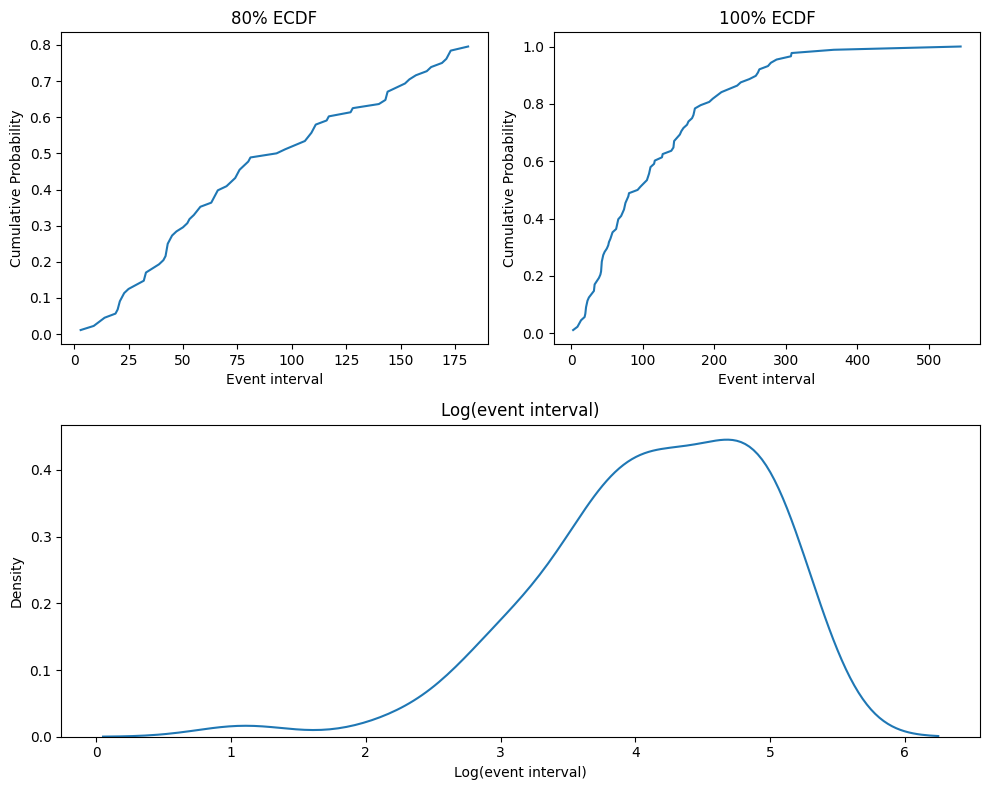

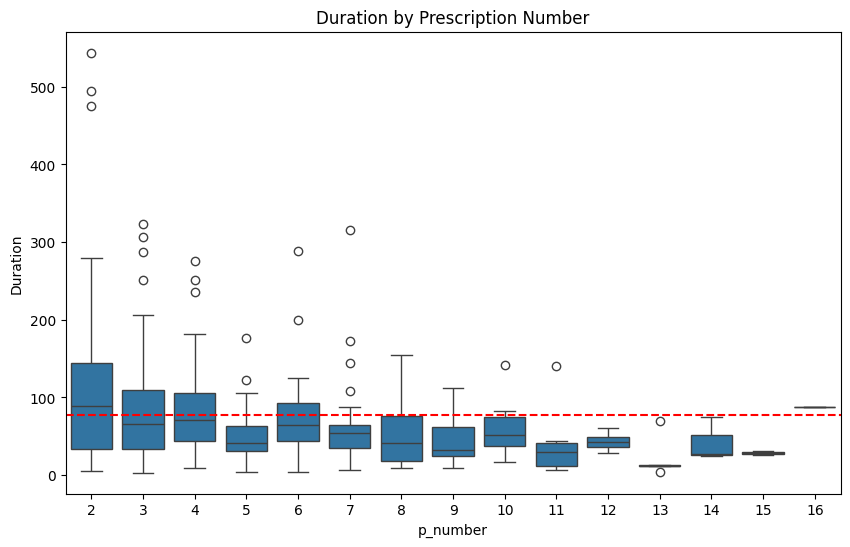

In [8]:
med_a_kmeans = SEE_KMeans("medA")

SEE_assumption(med_a_kmeans)

### DBSCAN

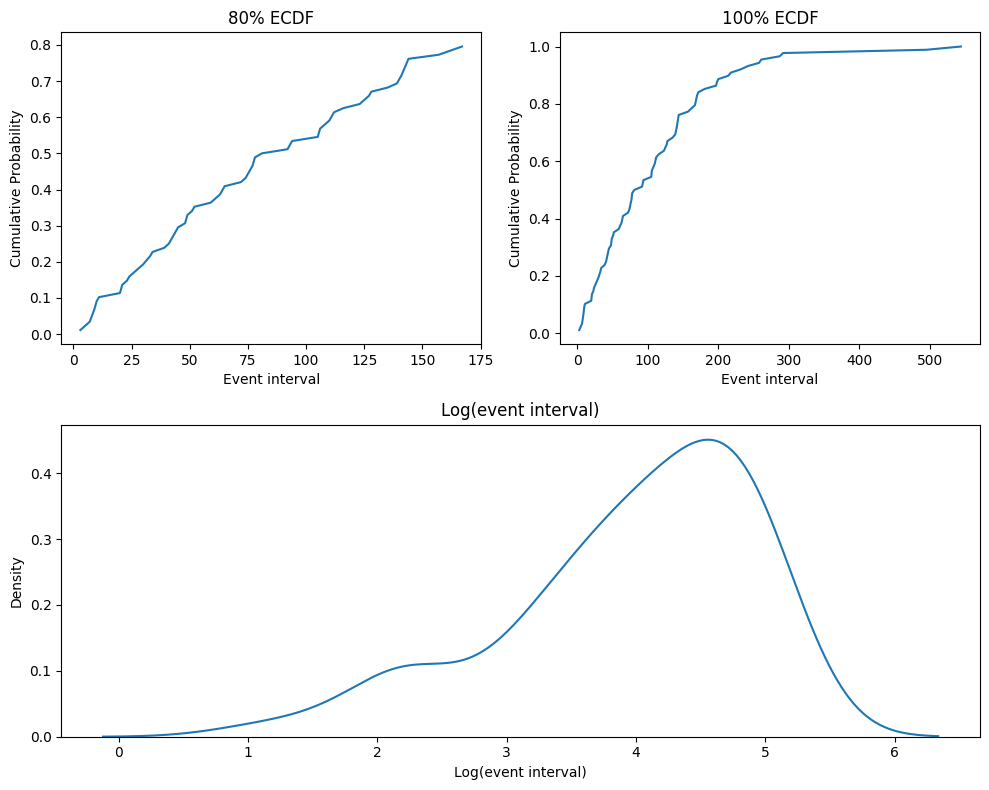

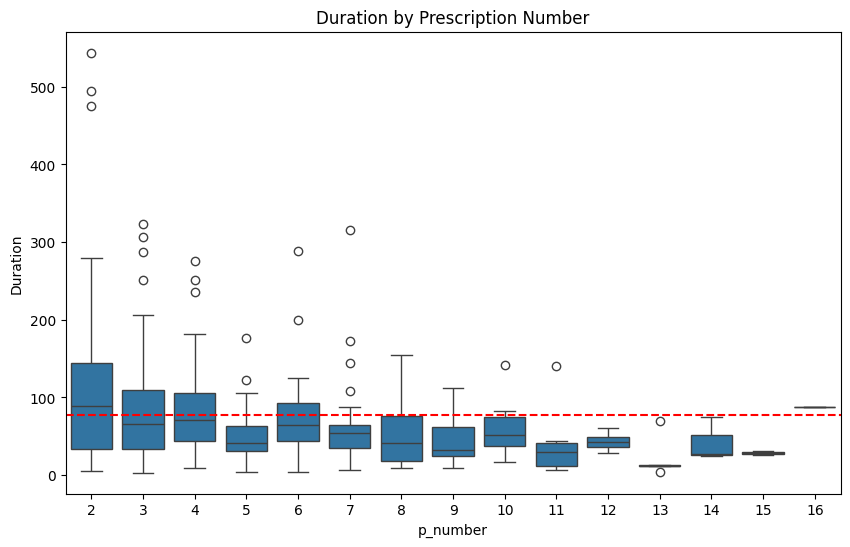

In [9]:
med_a_dbscan = SEE_DBSCAN("medA")

SEE_assumption(med_a_dbscan)

### Comparison

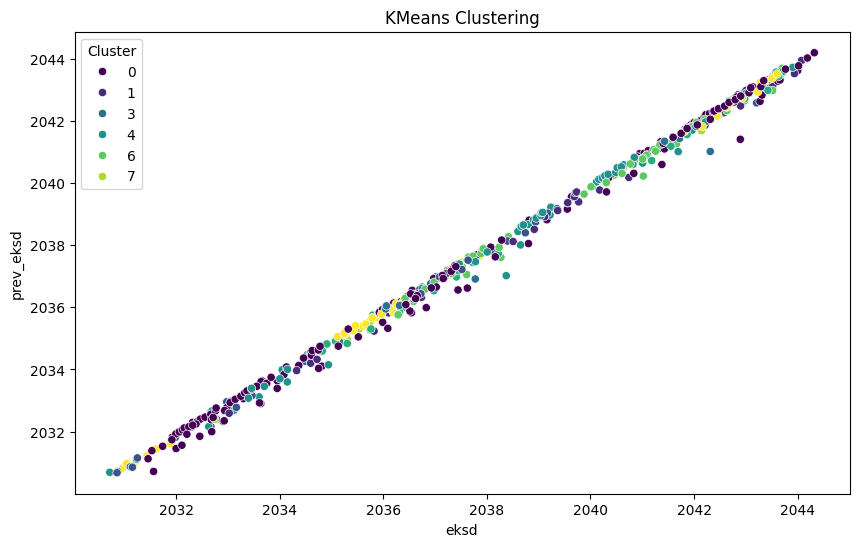

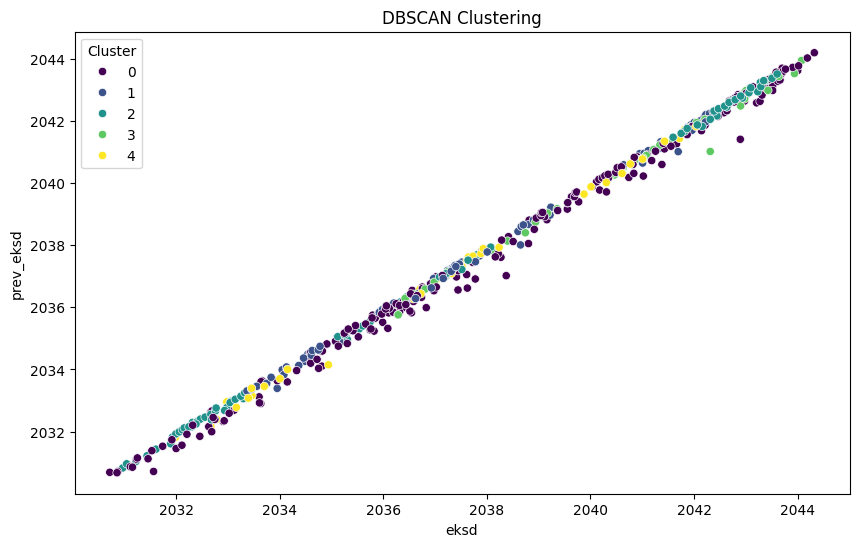

In [10]:
SEE_clustering_plot(med_a_kmeans, "KMeans")
SEE_clustering_plot(med_a_dbscan, "DBSCAN")

## SEE Clustering Comparision of ATC `medB`

### KMeans Clustering

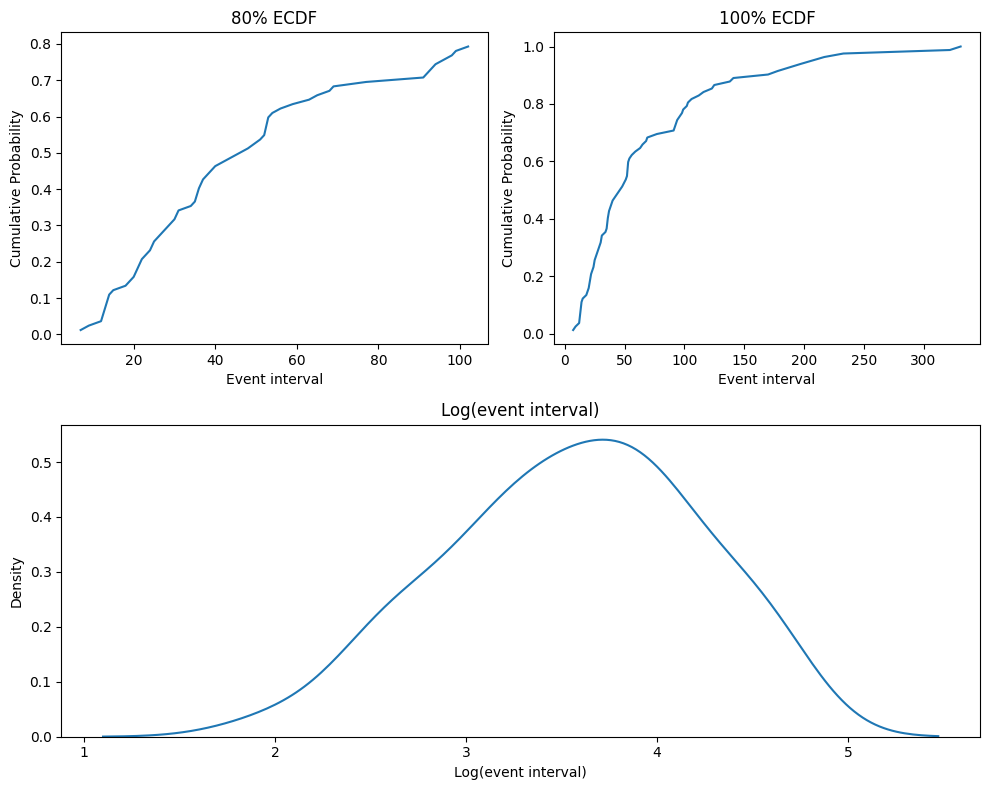

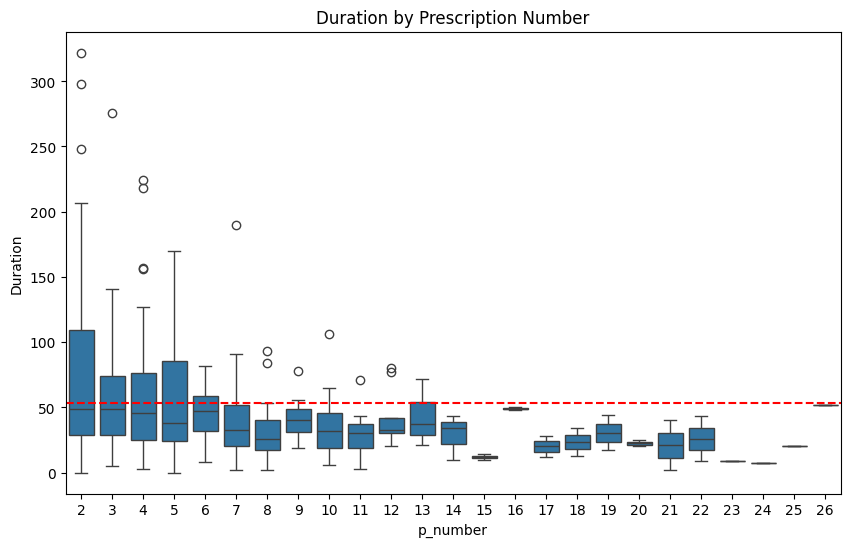

In [11]:
med_b_kmeans = SEE_KMeans("medB")

SEE_assumption(med_b_kmeans)

### DBSCAN

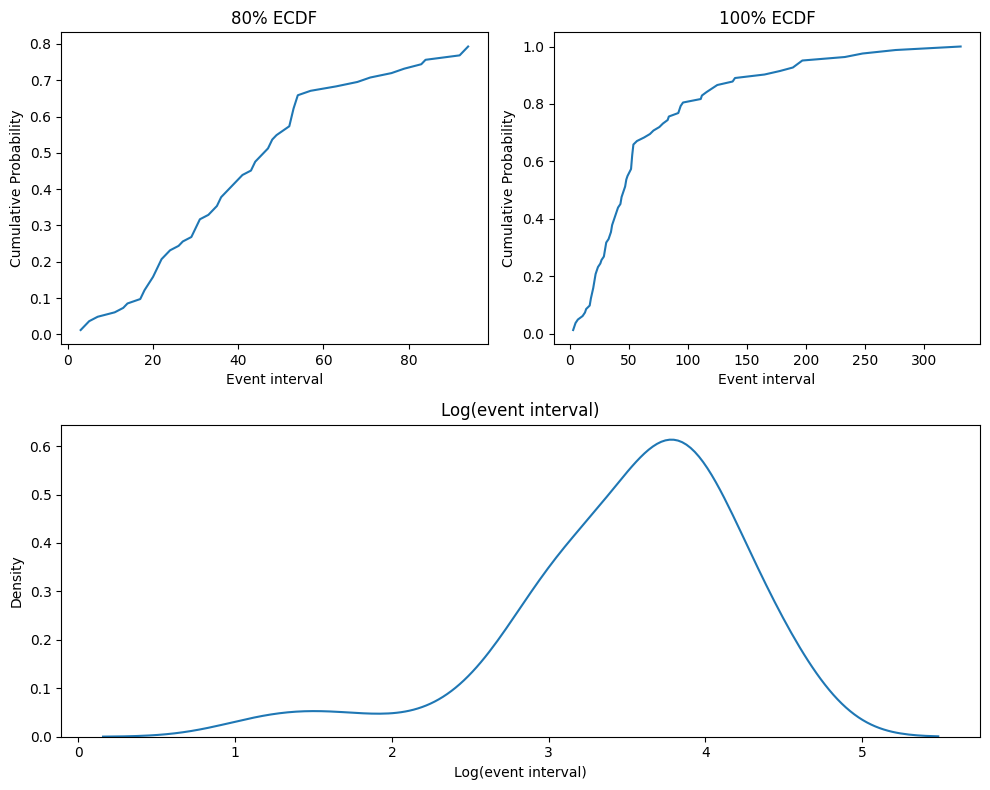

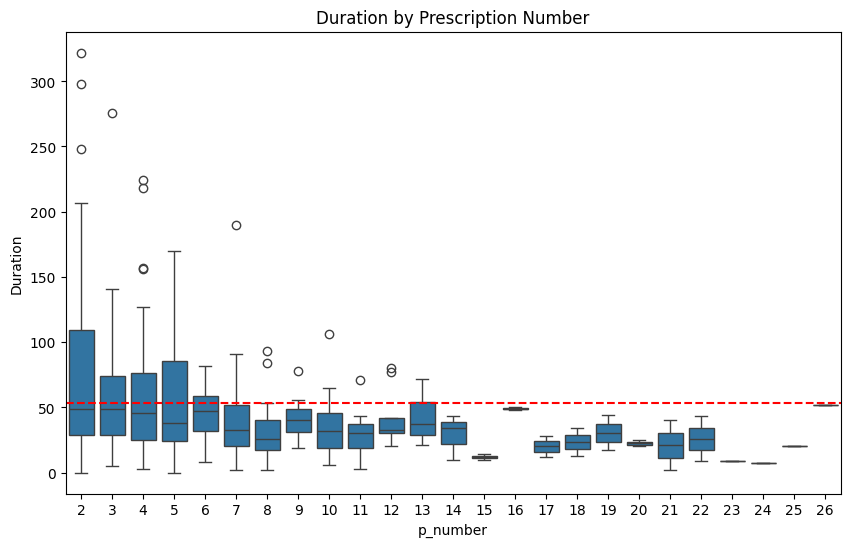

In [12]:
med_b_dbscan = SEE_DBSCAN("medB")

SEE_assumption(med_b_dbscan)

### Comparison

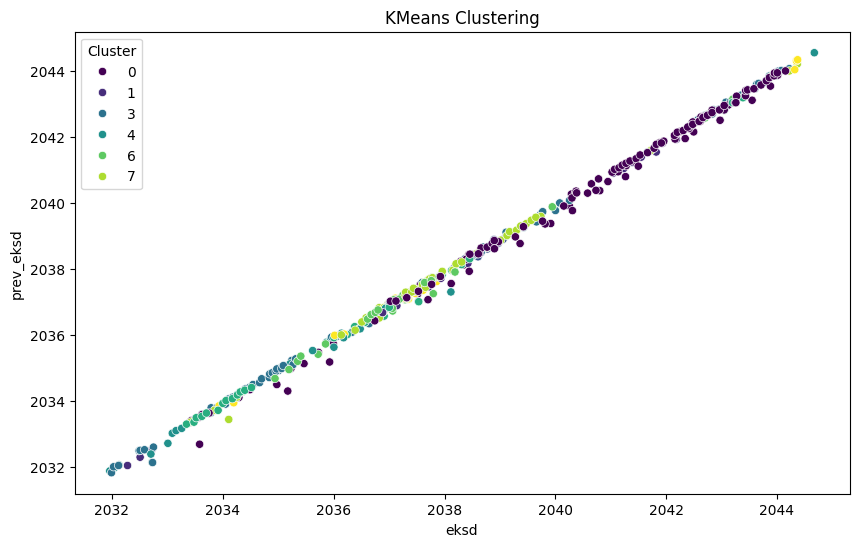

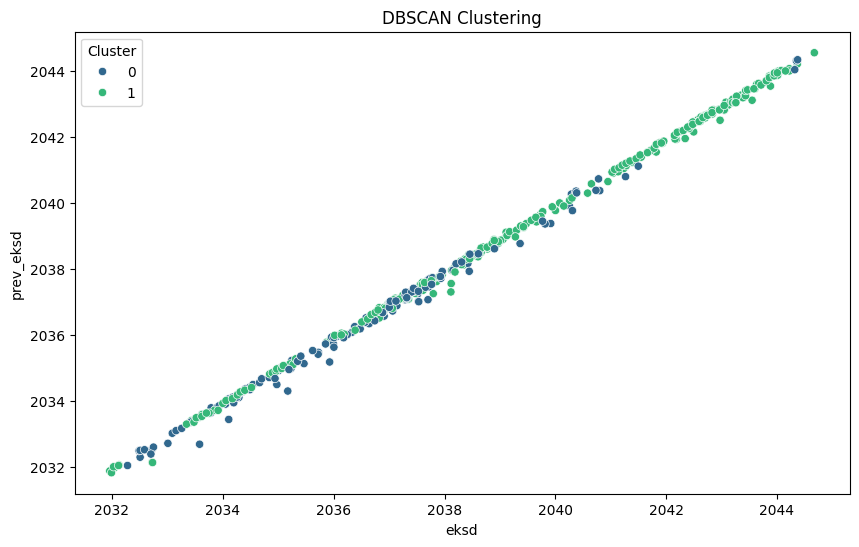

In [13]:
SEE_clustering_plot(med_b_kmeans, "KMeans")
SEE_clustering_plot(med_b_dbscan, "DBSCAN")

## Conclusion

In this notebook we:

- Implemented the Sessa Empirical Estimator (SEE) in Python by simulating refill data, computing refill gaps, filtering and standardizing the data, and clustering using K-Means.
- Replaced K-Means with DBSCAN as an alternative clustering algorithm to address some of K-Means' limitations.
- Compared the median "computed durations" from each method.

Our analysis demonstrates that the Sessa Empirical Estimator (SEE) can effectively derive an estimated duration for medication events based on refill data. By computing the empirical cumulative distribution (ECDF) of the gaps between prescription fills and retaining the lower $80$% of these intervals, we are able to filter out outlier values that might distort duration estimates. Clustering these filtered intervals—originally using k‑means and now alternatively with DBSCAN—enables us to assign each patient an estimated "duration" based on the median event interval within a cluster. The DBSCAN approach, in particular, avoids forcing all data into a predetermined number of clusters and can identify noise, potentially yielding more robust estimates when refill patterns are irregular.

### Insights

**ECDF and Filtering**

The ECDF plots (80% vs. 100%) clearly indicate that the majority of refill gaps fall within a certain range. By discarding the upper 20% of the distribution, the method minimizes the influence of unusually long gaps (which might occur due to treatment discontinuation or non‐persistence).

**Log Transformation**

Taking the logarithm of the event intervals helped normalize the distribution. This transformation is crucial for effective clustering because it reduces the impact of skewness and makes the data more amenable to grouping algorithms.

**Clustering Comparison**

- **K-Means**: Forces each point into one of a fixed number of clusters. Although effective, it can be sensitive to outliers and assumes clusters are spherical.
- **DBSCAN**: As an alternative, DBSCAN does not require pre-specifying the number of clusters and can identify noise points. This provides additional insights into the structure of refill data and may yield more robust groupings when the refill behavior is irregular.

**Practical Implications**

- The estimated durations derived from the clustering (median values from each cluster) serve as a data-driven proxy for the true prescription duration. These estimates can be critical when dose information is incomplete, thereby enhancing the accuracy of pharmacoepidemiological analyses.
- Differences observed between the clustering methods highlight that the choice of algorithm can affect the estimation. DBSCAN may offer advantages in real-world scenarios where refill patterns do not neatly fit into a predetermined number of groups.

**Visualization Layout**

The combined three-subplot layout provides a comprehensive visualization: the top row compares the $80$% and $100$% ECDFs, while the bottom plot shows the density of log-transformed event intervals. This arrangement not only makes the data exploration more intuitive but also supports decision-making regarding appropriate thresholding and clustering parameters.

### Summary

By applying the SEE method with both k-means and DBSCAN clustering on simulated refill data, we have illustrated how data-driven methods can be used to estimate medication duration when direct dosing information is absent. Our insights suggest that filtering the refill intervals via the ECDF and using a robust clustering approach—such as DBSCAN—can lead to more reliable and interpretable duration estimates, which in turn can enhance exposure assessments in pharmacoepidemiologic research.